In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:99% !important; }</style>"))

/tmp/ipykernel_10083/956813560.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [3]:
#chack for updated files\n,
%load_ext autoreload
%autoreload 2
#import packages
from __future__ import division

%load_ext line_profiler
import numpy as np
import glob, json
import pickle
import os as os_pack
import matplotlib.pyplot as plt
import corner
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import healpy as hp
import os, glob, json, pickle
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg as sl
import enterprise
from enterprise.pulsar import Pulsar
import enterprise.signals.parameter as parameter
from enterprise.signals import utils
from enterprise.signals import signal_base
from enterprise.signals import selections
from enterprise.signals.selections import Selection
from enterprise.signals import white_signals
from enterprise.signals import gp_signals
from enterprise.signals import deterministic_signals
import enterprise.constants as const
from enterprise_extensions import blocks
from enterprise_extensions import models as ee_models
from enterprise_extensions import model_utils as ee_model_utils
from enterprise_extensions import model_orfs
from enterprise_extensions.frequentist import optimal_statistic as opt_stat
from enterprise_extensions import sampler as ee_sampler
from enterprise.signals.signal_base import LogLikelihood
import enterprise_wavelets as models
from enterprise.signals.deterministic_signals import Deterministic
from enterprise.signals.parameter import function
from la_forge.core import Core
from la_forge.diagnostics import plot_chains
from la_forge import rednoise
import la_forge
import corner
from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc
import re
#style
    
#import Fast_Burst_likelihood as FB

In [4]:
def figsize(scale):
    fig_width_pt = 513.17 #469.755                  # Get this from LaTeX using \the\textwidth
    inches_per_pt = 1.0/72.27                       # Convert pt to inch
    golden_mean = (np.sqrt(5.0)-1.0)/2.0            # Aesthetic ratio (you could change this)
    fig_width = fig_width_pt*inches_per_pt*scale    # width in inches
    fig_height = fig_width*golden_mean              # height in inches
    fig_size = [2 * fig_width,2 * fig_height]       #1* scaling factor for 2 collem paper
    return fig_size
plt.rcParams.update(plt.rcParamsDefault)

params = {'backend': 'pdf',
        'axes.labelsize': 10,
        'lines.markersize': 4,
        'font.size': 10,
        'xtick.major.size':6,
        'xtick.minor.size':3,  
        'ytick.major.size':6,
        'ytick.minor.size':3, 
        'xtick.major.width':0.5,
        'ytick.major.width':0.5,
        'xtick.minor.width':0.5,
        'ytick.minor.width':0.5,
        'lines.markeredgewidth':1,
        'axes.linewidth':1.2,
        'legend.fontsize': 7,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'savefig.dpi':200,
        'path.simplify':True,
        'font.family': 'serif',
        #'font.serif':'Times',
        #'text.latex.preamble': [r'\usepackage{amsmath}'],
        #'text.usetex':True,
        'figure.figsize': figsize(0.5)}
#plt.style.use('dark_background')
plt.style.use('default')
plt.rcParams.update(params)

In [5]:
#Loading in pickle and noise files
pint_pickle = '/home/reyna/OS_15yr/15yr_data/v1p1_de440_pint_bipm2019.pkl'
noise_file = '/home/reyna/OS_15yr/15yr_data/v1p1_wn_dict.json'
#psrlist = np.loadtxt('/home/reyna/15yr_v1p0/15yr_v1-20211001T235643Z-001/15yr_v1/psrlist_15yr_pint.txt', dtype = str)
with open(noise_file, 'r') as h:
    noise_params = json.load(h)
with open(pint_pickle,'rb') as f:
    allpsrs = pickle.load(f)
psrs = []
for ii,p in enumerate(allpsrs):
    psrs.append(p)
#Temporary to get code to not crash
psrs = psrs[0:]
psrlist = [psr.name for psr in psrs]
print(psrlist)
for i in range(len(psrs)):
    print((max(psrs[i].toas) - min(psrs[i].toas))/(3.17*10**(7)))

['B1855+09', 'B1937+21', 'B1953+29', 'J0023+0923', 'J0030+0451', 'J0340+4130', 'J0406+3039', 'J0437-4715', 'J0509+0856', 'J0557+1551', 'J0605+3757', 'J0610-2100', 'J0613-0200', 'J0636+5128', 'J0645+5158', 'J0709+0458', 'J0740+6620', 'J0931-1902', 'J1012+5307', 'J1012-4235', 'J1022+1001', 'J1024-0719', 'J1125+7819', 'J1312+0051', 'J1453+1902', 'J1455-3330', 'J1600-3053', 'J1614-2230', 'J1630+3734', 'J1640+2224', 'J1643-1224', 'J1705-1903', 'J1713+0747', 'J1719-1438', 'J1730-2304', 'J1738+0333', 'J1741+1351', 'J1744-1134', 'J1745+1017', 'J1747-4036', 'J1751-2857', 'J1802-2124', 'J1811-2405', 'J1832-0836', 'J1843-1113', 'J1853+1303', 'J1903+0327', 'J1909-3744', 'J1910+1256', 'J1911+1347', 'J1918-0642', 'J1923+2515', 'J1944+0907', 'J1946+3417', 'J2010-1323', 'J2017+0603', 'J2033+1734', 'J2043+1711', 'J2124-3358', 'J2145-0750', 'J2214+3000', 'J2229+2643', 'J2234+0611', 'J2234+0944', 'J2302+4442', 'J2317+1439', 'J2322+2057']
15.515060297068947
15.802872967471835
11.08458774068679
8.975425297

In [6]:
glitches = []
N_glitches = 5
for i in range(N_glitches):
    log10_f0 = parameter.Uniform(np.log10(3.5e-9), np.log10(1e-7))("Glitch_"+str(i)+'_'+'log10_f0')
    phase0 = parameter.Uniform(0, 2*np.pi)("Glitch_"+str(i)+'_'+'phase0')
    tau = parameter.Uniform(0.2, 5)("Glitch_"+str(i)+'_'+'tau')
    t0 = parameter.Uniform(0.0, 10.0)("Glitch_"+str(i)+'_'+'t0')
    psr_idx = parameter.Uniform(-0.5, len(psrs)-0.5)("Glitch_"+str(i)+'_'+'psr_idx')
    log10_h = parameter.LinearExp(-10.5, -9)("Glitch_"+str(i)+'_'+'log10_h')
    glitch_wf = models.glitch_delay(log10_h = log10_h, tau = tau, log10_f0 = log10_f0, t0 = t0, phase0 = phase0, tref=53000*86400,
                                            psr_float_idx = psr_idx, pulsars=psrs)
    glitches.append(deterministic_signals.Deterministic(glitch_wf, name='Glitch'+str(i) ))

In [7]:
#wavelet models
wavelets = [] #added "wavelet_" to names to help with seperation
N_wavelets = 5
for i in range(N_wavelets):
    log10_f0 = parameter.Uniform(np.log10(3.5e-9), np.log10(1e-7))("wavelet_"+str(i)+'_'+'log10_f0')
    cos_gwtheta = parameter.Uniform(-1, 1)("wavelet_"+str(i)+'_'+'cos_gwtheta')
    gwphi = parameter.Uniform(0, 2*np.pi)("wavelet_"+str(i)+'_'+'gwphi')
    psi = parameter.Uniform(0, np.pi)("wavelet_"+str(i)+'_'+'gw_psi')
    phase0 = parameter.Uniform(0, 2*np.pi)("wavelet_"+str(i)+'_'+'phase0')
    phase0_cross = parameter.Uniform(0, 2*np.pi)("wavelet_"+str(i)+'_'+'phase0_cross')
    tau = parameter.Uniform(0.2, 5)("wavelet_"+str(i)+'_'+'tau')
    t0 = parameter.Uniform(0.0, 10.0)("wavelet_"+str(i)+'_'+'t0')
    log10_h = parameter.LinearExp(-18,-11)("wavelet_"+str(i)+'_'+'log10_h')
    log10_h_cross = parameter.LinearExp(-18,-11)("wavelet_"+str(i)+'_'+'log10_h_cross')
    wavelet_wf = models.wavelet_delay(cos_gwtheta=cos_gwtheta, gwphi=gwphi, log10_h = log10_h, log10_h2=log10_h_cross,
                                      tau = tau, log10_f0 = log10_f0, t0 = t0, phase0 = phase0, phase02=phase0_cross,
                                      epsilon = None, psi=psi, tref=53000*86400)
    wavelets.append(deterministic_signals.Deterministic(wavelet_wf, name='wavelet'+str(i)))

In [8]:
tm = gp_signals.TimingModel(use_svd=True)
wn = blocks.white_noise_block(vary=False, inc_ecorr=True)

Tspan = ee_model_utils.get_tspan(psrs)
rn = blocks.red_noise_block(psd='powerlaw', prior = 'log-uniform', Tspan=Tspan, components = 30)

fgamma = 13./3.
vary_gamma = parameter.Uniform(0,7)('gw_gamma')
log10_A = parameter.Uniform(-18,-11)('gw_log10_A')
com_comp = 14  
pl = utils.powerlaw(log10_A=log10_A, gamma = vary_gamma)
crn = gp_signals.FourierBasisGP(spectrum=pl, components = com_comp, Tspan=Tspan, name='gw')

#s = base_model
s = tm + wn + rn + crn 
for i in range(N_glitches):
    s += glitches[i]
for j in range(N_wavelets):
    s += wavelets[j]
model = []
for p in psrs:
    model.append(s(p))
with open(noise_file, 'r') as fp:
    noisedict = json.load(fp)
    pta = signal_base.PTA(model)
    pta.set_default_params(noisedict)

In [9]:
d0_15y = parameter.sample(pta.params)
x0_15y = np.array([d0_15y[par.name] for par in pta.params])

In [27]:
d0_15y[list(d0_15y)[1]] = 4
print(d0_15y[list(d0_15y)[1]])

4


In [14]:
noise_params

{'B1855+09_430_ASP_efac': 1.115935306813982,
 'B1855+09_430_ASP_log10_t2equad': -7.564164330699591,
 'B1855+09_430_PUPPI_efac': 1.000049037085653,
 'B1855+09_430_PUPPI_log10_t2equad': -6.572540211467256,
 'B1855+09_L-wide_ASP_efac': 1.043114017270374,
 'B1855+09_L-wide_ASP_log10_t2equad': -6.517929916655293,
 'B1855+09_L-wide_PUPPI_efac': 1.1118432332882,
 'B1855+09_L-wide_PUPPI_log10_t2equad': -7.755603780476984,
 'B1855+09_430_ASP_log10_ecorr': -6.798122106550257,
 'B1855+09_430_PUPPI_log10_ecorr': -5.6989064141929715,
 'B1855+09_L-wide_ASP_log10_ecorr': -6.120457109433745,
 'B1855+09_L-wide_PUPPI_log10_ecorr': -6.641667916624413,
 'B1855+09_red_noise_log10_A': -13.940953818371378,
 'B1855+09_red_noise_gamma': -3.68432133461766,
 'B1937+21_L-wide_ASP_efac': 2.584236583895852,
 'B1937+21_L-wide_ASP_log10_t2equad': -7.240258825889674,
 'B1937+21_L-wide_PUPPI_efac': 1.588553615548855,
 'B1937+21_L-wide_PUPPI_log10_t2equad': -7.316718019537581,
 'B1937+21_Rcvr1_2_GASP_efac': 1.1159623803

In [ ]:

def get_efacequad_indices(pta):
    ind = []
    if 'basis' in ecorr_type:
        for ct, par in enumerate(param_names):
            if 'efac' in par or 'equad' in par:
                ind.append(ct)
    else:
        for ct, par in enumerate(self.param_names):
            if 'ecorr' in par or 'efac' in par or 'equad' in par:
                ind.append(ct)
    return np.array(ind)


def get_basis_ecorr_indices(self):
    ind = []
    for ct, par in enumerate(self.param_names):
        if 'ecorr' in par:
            ind.append(ct)
    return np.array(ind)

for ct, par in enumerate(self.param_names):
    if 'ecorr' in par or 'efac' in par or 'equad' in par:
        ind.append(ct)





In [136]:
num_wn_param_lists = []
wn_indx_param_list = []
indexing = 0
#For each pulsar
for i in range(len(psrs)):
    param_list = pta.pulsarmodels[i].param_names
    psr_wn_indx = []
    #Search through all parameters to get indexes for rn and wn params for each pulsar (skip gwb terms)
    for ct, par in enumerate(param_list):
        if psrs[i].name in par:
            if 'ecorr' in par or 'efac' in par or 'equad' in par or 'log10_A' in par or 'gamma' in par:

                #get indexes for each pulsar from overall pta params
                psr_wn_indx.append(pta.param_names.index(par))
                
    #append to overall list of lists
    wn_indx_param_list.append(psr_wn_indx)
    num_wn_param_lists.append(len(psr_wn_indx))


In [137]:
print(pta.param_names.index('gw_log10_A'))
print(sum(num_wn_param_lists))
print(wn_indx_param_list)
num_wn_param_lists
#print(sum(num_wn_param_lists))

810
779
[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13], [14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39], [40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56], [87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100], [101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117], [118, 119, 120, 121, 122, 123, 124, 125], [126, 127, 128, 129, 130, 131, 132, 133], [134, 135, 136, 137, 138, 139, 140, 141], [142, 143, 144, 145, 146, 147, 148, 149], [150, 151, 152, 153, 154, 155, 156, 157], [158, 159, 160, 161, 162, 163, 164, 165], [166, 167, 168, 169, 170, 171, 172, 173], [174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187], [188, 189, 190, 191, 192, 193, 194, 195], [196, 197, 198, 199, 200, 201, 202, 203], [204, 205, 206, 207, 208, 209, 210, 211], [212, 213, 214, 215, 216, 217, 218, 219], [220, 221, 222, 223, 224, 225, 226, 227], [228, 229, 230, 231, 232, 233, 234, 235, 236,

[14,
 26,
 17,
 14,
 17,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 14,
 8,
 8,
 8,
 8,
 8,
 14,
 8,
 11,
 14,
 8,
 8,
 11,
 14,
 17,
 14,
 8,
 14,
 17,
 8,
 32,
 8,
 8,
 14,
 17,
 14,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 14,
 17,
 17,
 14,
 8,
 14,
 14,
 17,
 8,
 14,
 14,
 8,
 14,
 8,
 14,
 11,
 8,
 8,
 8,
 8,
 17,
 11]

In [71]:
#print(pta.pulsarmodels[i].param_names)
#for i in range(len(psrs)):

for ct, par in enumerate(self.param_names):
    if 'ecorr' in par:
        ec_indx.append(ct)
    if 'efac' in par:
        ef_indx.append(ct)
    if 'equad' in par:
        eq_indx.append(ct)
print(''ec_indx)

['B1855+09_430_ASP_efac', 'B1855+09_430_ASP_log10_t2equad', 'B1855+09_430_PUPPI_efac', 'B1855+09_430_PUPPI_log10_t2equad', 'B1855+09_L-wide_ASP_efac', 'B1855+09_L-wide_ASP_log10_t2equad', 'B1855+09_L-wide_PUPPI_efac', 'B1855+09_L-wide_PUPPI_log10_t2equad', 'Glitch_0_log10_f0', 'Glitch_0_log10_h', 'Glitch_0_phase0', 'Glitch_0_psr_idx', 'Glitch_0_t0', 'Glitch_0_tau', 'Glitch_1_log10_f0', 'Glitch_1_log10_h', 'Glitch_1_phase0', 'Glitch_1_psr_idx', 'Glitch_1_t0', 'Glitch_1_tau', 'Glitch_2_log10_f0', 'Glitch_2_log10_h', 'Glitch_2_phase0', 'Glitch_2_psr_idx', 'Glitch_2_t0', 'Glitch_2_tau', 'Glitch_3_log10_f0', 'Glitch_3_log10_h', 'Glitch_3_phase0', 'Glitch_3_psr_idx', 'Glitch_3_t0', 'Glitch_3_tau', 'Glitch_4_log10_f0', 'Glitch_4_log10_h', 'Glitch_4_phase0', 'Glitch_4_psr_idx', 'Glitch_4_t0', 'Glitch_4_tau', 'wavelet_0_cos_gwtheta', 'wavelet_0_gw_psi', 'wavelet_0_gwphi', 'wavelet_0_log10_f0', 'wavelet_0_log10_h', 'wavelet_0_log10_h_cross', 'wavelet_0_phase0', 'wavelet_0_phase0_cross', 'wavelet

In [10]:
d0_15y_2 = parameter.sample(pta.params)

In [11]:
for n in range(N_glitches):
    d0_15y_2['Glitch_'+str(n)+'_log10_f0'] = d0_15y['Glitch_'+str(n)+'_log10_f0']
    d0_15y_2['Glitch_'+str(n)+'_psr_idx'] = d0_15y['Glitch_'+str(n)+'_psr_idx']
    d0_15y_2['Glitch_'+str(n)+'_t0'] = d0_15y['Glitch_'+str(n)+'_t0']
    d0_15y_2['Glitch_'+str(n)+'_tau'] = d0_15y['Glitch_'+str(n)+'_tau']
for w in range(N_wavelets):
    d0_15y_2['wavelet_'+str(w)+'_log10_f0'] = d0_15y['wavelet_'+str(w)+'_log10_f0']
    d0_15y_2['wavelet_'+str(w)+'_t0'] = d0_15y['wavelet_'+str(w)+'_t0']
    d0_15y_2['wavelet_'+str(w)+'_tau'] = d0_15y['wavelet_'+str(w)+'_tau']

In [12]:
x0_15y_2 = np.array([d0_15y_2[par.name] for par in pta.params])

In [88]:
%lprun -f pta.get_lnlikelihood pta.get_lnlikelihood(x0_15y)

In [94]:
%lprun -f pta.get_lnlikelihood pta.get_lnlikelihood(x0_15y_2)

In [11]:
import Fast_Burst_likelihood as FB

In [15]:
rn = True
wn = False
FB_15y = FB.FastBurst(pta = pta, psrs = psrs, params = d0_15y, Npsr = len(psrs), tref=53000*86400, Nglitch = N_glitches, Nwavelet = N_wavelets, rn_vary = rn, wn_vary = wn)

ValueError: [1mCannot determine Numba type of <class 'enterprise.signals.signal_base.ShermanMorrison'>[0m

In [112]:
%lprun -f FB_15y.get_lnlikelihood FB_15y.get_lnlikelihood(x0_15y)

In [86]:
FB_15y.save_values(accept_new_step=True)

In [56]:
%timeit FB_15y.get_lnlikelihood(x0_15y_2)

63.4 µs ± 1.08 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [52]:
%lprun -f FB_15y.get_lnlikelihood FB_15y.get_lnlikelihood(x0_15y_2)

/home/reyna/anaconda3/envs/ent/lib/python3.9/site-packages/numpy/lib/function_base.py:935: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [132]:
NN = 20

log_L_Ent_15y = []
log_L_Fast_15y = []
#amplitudes = []

for n in range(NN):
    #amplitudes.append(i*0.5e-6)
    d0_15y = parameter.sample(pta.params)
    x0_15y = np.array([d0_15y[par.name] for par in pta.params])
    
    log_L_Ent_15y.append(pta.get_lnlikelihood(x0_15y))
    log_L_Fast_15y.append(FB_15y.get_lnlikelihood(x0_15y))
    FB_15y.save_values(accept_new_step=True)
    print('run ',n)

run  0
run  1
run  2
run  3
run  4
run  5
run  6
run  7
run  8
run  9
run  10
run  11
run  12
run  13
run  14
run  15
run  16
run  17
run  18
run  19


In [133]:
log_L_Ent_15y = np.array(log_L_Ent_15y)
log_L_Fast_15y = np.array(log_L_Fast_15y)

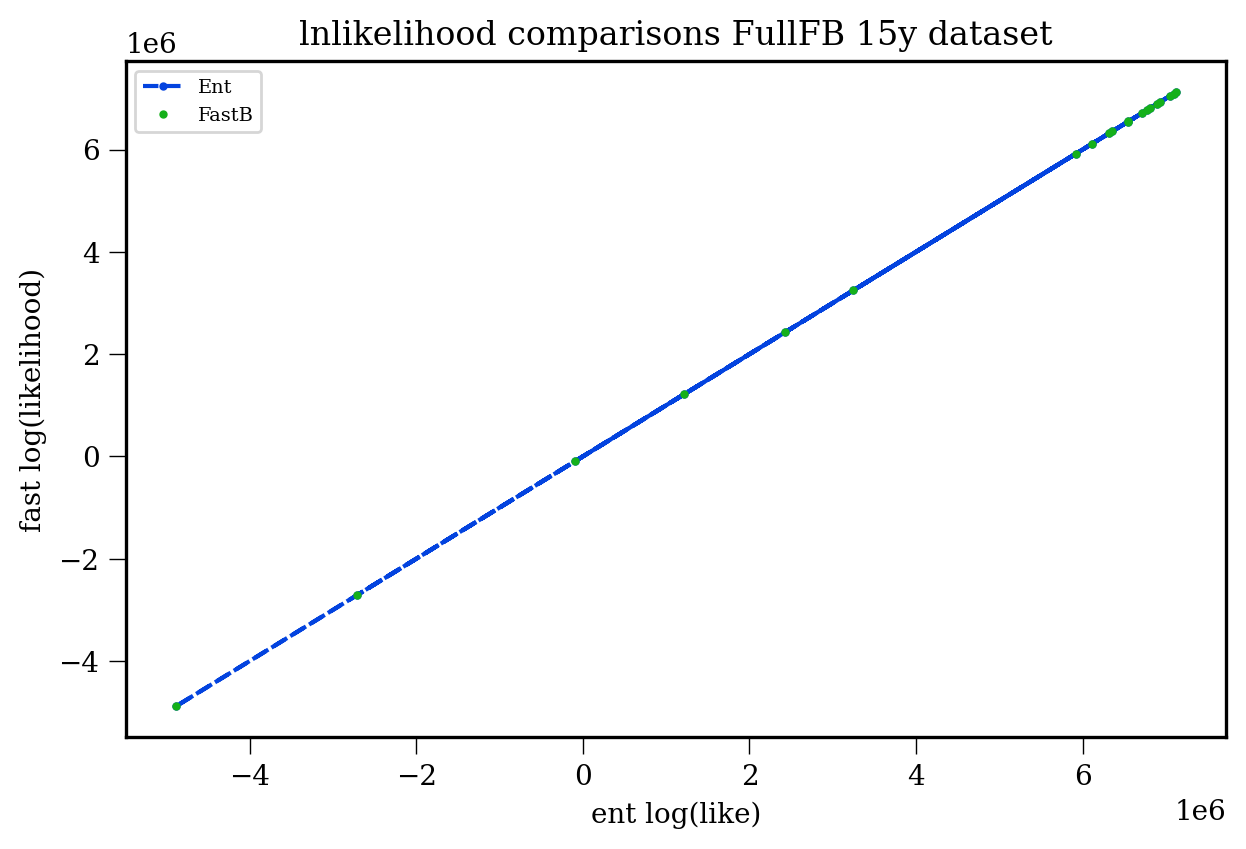

In [134]:
plt.figure()
plt.plot(log_L_Ent_15y, log_L_Ent_15y, ls='--', marker='.', color='xkcd:blue', label = 'Ent')
plt.plot(log_L_Ent_15y, log_L_Fast_15y, ls='', marker='.', color='xkcd:green', label = 'FastB')
plt.legend(loc='upper left')
plt.xlabel("ent log(like)")
plt.ylabel("fast log(likelihood)")
plt.title('lnlikelihood comparisons FullFB 15y dataset')
#plt.savefig('/home/reyna/BayesHopperBurst/testing plots/FullFastBurst_15y_lnlikedif.pdf')
plt.show()

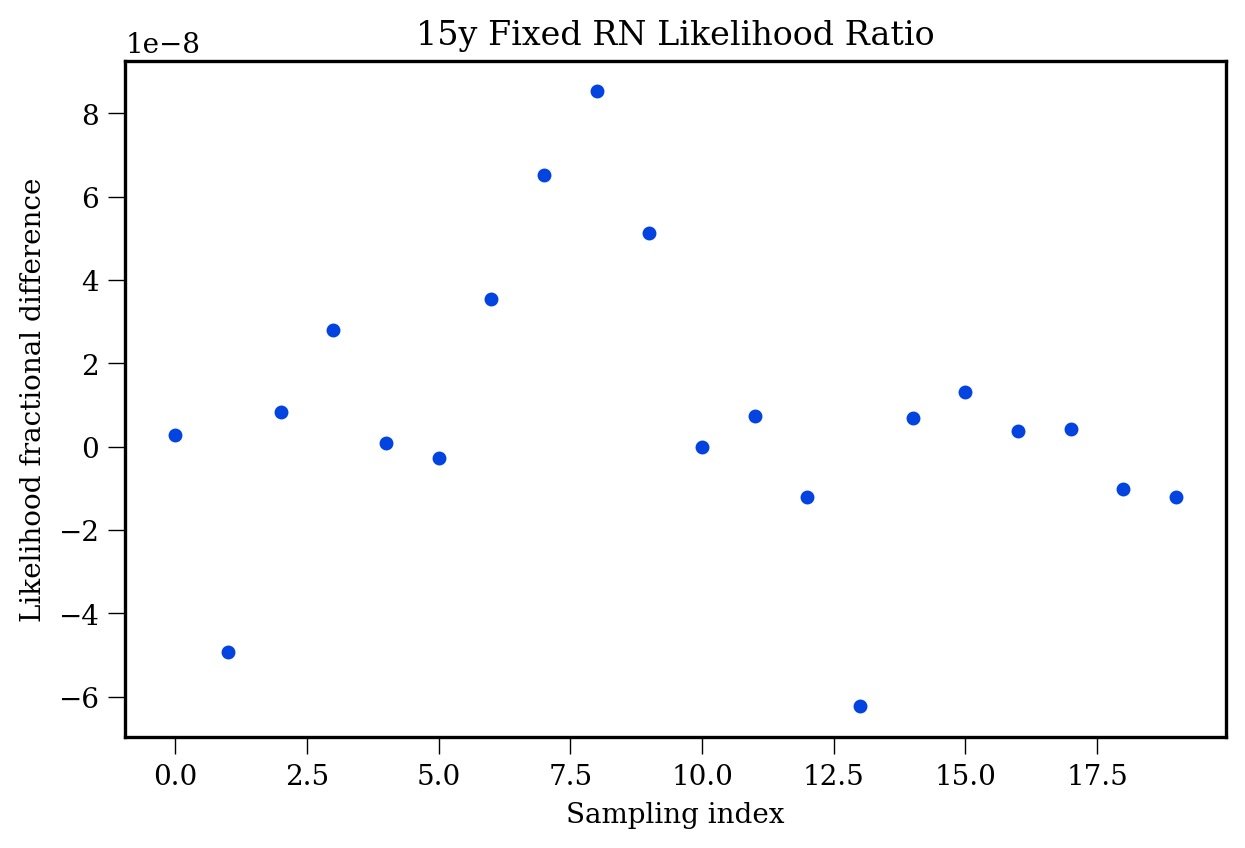

In [135]:
plt.plot(np.exp(log_L_Fast_15y - log_L_Ent_15y)-1, ls='', marker='o', color='xkcd:blue')
#plt.hlines(y = 0, xmin = 0, xmax = 50, ls = '--', color = 'black')
#plt.gca().axhline(0.1, ls='--', color='xkcd:green')
plt.xlabel("Sampling index")
#plt.xscale('log')
plt.ylabel("Likelihood fractional difference")
plt.title('15y Fixed RN Likelihood Ratio')
#plt.savefig('/home/reyna/BayesHopperBurst/testing plots/15y_like_dif_RN_fixed.pdf', transparent=True)
plt.show()

In [217]:
np.exp(log_L_Fast_15y - log_L_Ent_15y)-1

array([-5.88597171e-05, -3.14757294e-02,  3.15960719e-03, -3.74510587e-04,
        2.56172584e-03,  1.86877361e+00,  3.95107463e-03, -4.82185972e-01,
        1.63424143e-04,  2.62747881e-03,  1.26856640e+00,  4.61364136e-01,
        4.52718456e-02, -6.91764698e-01, -1.30117558e-02, -3.66185919e-03,
       -8.66731390e-03, -5.17505579e-01,  2.01258531e-02, -1.24064745e-02])

In [218]:
log_L_Fast_15y

array([7957928.81077643, 7956298.51421408, 7956914.35981946,
       7939994.60790684, 7957902.0161521 , 7892979.39598267,
       7950904.11544481, 7955141.1117899 , 7937419.91981984,
       7954647.08090582, 7867712.38403108, 7958372.75330197,
       7958489.19622281, 7575634.73628175, 7958941.25543993,
       7956775.86110597, 7952457.30782962, 7575456.35610329,
       7939127.5419339 , 7958435.94640814])

In [121]:
FB_15y = FB.FastBurst(pta = pta, psrs = psrs, params = d0_15y, Npsr = len(psrs), tref=53000*86400, Nglitch = N_glitches, Nwavelet = N_wavelets)

In [176]:
#%%prun
NN = 30

log_L_Ent_15y_shaped = []
log_L_Fast_15y_shaped = []

for s in range(NN):
    d0_15y_2 = parameter.sample(pta.params)
    for n in range(N_glitches):
        d0_15y_2['Glitch_'+str(n)+'_log10_f0'] = d0_15y['Glitch_'+str(n)+'_log10_f0']
        d0_15y_2['Glitch_'+str(n)+'_psr_idx'] = d0_15y['Glitch_'+str(n)+'_psr_idx']
        d0_15y_2['Glitch_'+str(n)+'_t0'] = d0_15y['Glitch_'+str(n)+'_t0']
        d0_15y_2['Glitch_'+str(n)+'_tau'] = d0_15y['Glitch_'+str(n)+'_tau']
    for w in range(N_wavelets):
        d0_15y_2['wavelet_'+str(w)+'_log10_f0'] = d0_15y['wavelet_'+str(w)+'_log10_f0']
        d0_15y_2['wavelet_'+str(w)+'_t0'] = d0_15y['wavelet_'+str(w)+'_t0']
        d0_15y_2['wavelet_'+str(w)+'_tau'] = d0_15y['wavelet_'+str(w)+'_tau']
    x0_15y_2 = np.array([d0_15y_2[par.name] for par in pta.params])

    log_L_Ent_15y_shaped.append(pta.get_lnlikelihood(x0_15y_2))
    log_L_Fast_15y_shaped.append(FB_15y.get_lnlikelihood(x0_15y_2))
    print('run ',s)
    
log_L_Ent_15y_shaped = np.array(log_L_Ent_15y_shaped)
log_L_Fast_15y_shaped = np.array(log_L_Fast_15y_shaped)

run  0
run  1
run  2
run  3
run  4
run  5
run  6
run  7
run  8
run  9
run  10
run  11
run  12
run  13
run  14
run  15
run  16
run  17
run  18
run  19
run  20
run  21
run  22
run  23
run  24
run  25
run  26
run  27
run  28
run  29


Text(0.5, 1.0, 'lnlikelihood comparisons FullFB 15y dataset')

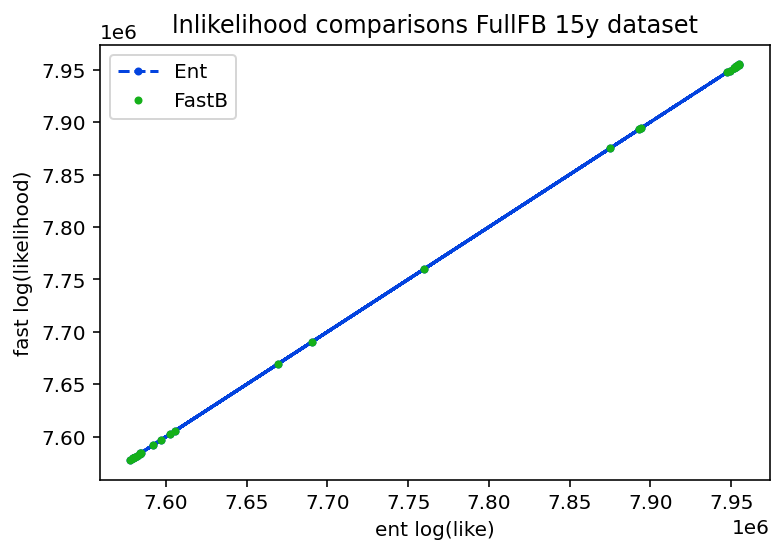

In [177]:
plt.plot(log_L_Ent_15y_shaped, log_L_Ent_15y_shaped, ls='--', marker='.', color='xkcd:blue', label = 'Ent')
plt.plot(log_L_Ent_15y_shaped, log_L_Fast_15y_shaped, ls='', marker='.', color='xkcd:green', label = 'FastB')
plt.legend(loc='upper left')
plt.xlabel("ent log(like)")
plt.ylabel("fast log(likelihood)")
plt.title('lnlikelihood comparisons FullFB 15y dataset')
#plt.savefig('/home/reyna/BayesHopperBurst/testing plots/FullFastBurst_15y_lnlikedif.png')

In [27]:
plt.plot(np.exp(log_L_Fast_15y_shaped - log_L_Ent_15y_shaped), ls='', marker='.', color='xkcd:blue')
#plt.gca().axhline(0.1, ls='--', color='xkcd:green')
plt.xlabel("index")
plt.ylabel("delta log(likelihood)")
plt.title('val dif for randome samples 15y')
#plt.savefig('/home/reyna/BayesHopperBurst/testing plots/FullFastBurst_15y_precentdif.png')
plt.show()

NameError: name 'log_L_Fast_15y_shaped' is not defined

In [37]:
%lprun -f QuickBurst_MCMC.run_bhb QuickBurst_MCMC.run_bhb(N, T_max, n_chain, psrs,max_n_wavelet=5,min_n_wavelet=0,n_wavelet_start=3,RJ_weight=0,glitch_RJ_weight=0,regular_weight=4,noise_jump_weight=0,PT_swap_weight=1,tau_scan_proposal_weight=0,glitch_tau_scan_proposal_weight=0,gwb_switch_weight=0,rn_log_amp_range=[-18,-15],wavelet_log_amp_range=[-10.0,-5],per_psr_rn_log_amp_range=[-18,-15],prior_recovery=False,rn_amp_prior='log-uniform',wavelet_amp_prior='uniform',per_psr_rn_amp_prior='log-uniform',max_n_glitch=5,n_glitch_start=1,glitch_log_amp_range=[-10.0,-5],glitch_amp_prior='uniform',t0_max=10,draw_from_prior_weight=0, de_weight=0,vary_white_noise=True,include_gwb=False,include_rn=False, vary_rn=False,include_equad_ecorr=False,wn_backend_selection=False,noisedict_file=noise_file,include_per_psr_rn=False,vary_per_psr_rn=False,savefile=savefile, save_every_n=1)

/home/reyna/BayesHopperBurst/QuickBurst/QuickBurst_MCMC.py:202: SyntaxWarning: "is" with a literal. Did you mean "=="?
/home/reyna/BayesHopperBurst/QuickBurst/QuickBurst_MCMC.py:207: SyntaxWarning: "is" with a literal. Did you mean "=="?


['B1855+09_efac', 'B1937+21_efac', 'B1953+29_efac', 'Glitch_0_log10_f0', 'Glitch_0_log10_h', 'Glitch_0_phase0', 'Glitch_0_psr_idx', 'Glitch_0_t0', 'Glitch_0_tau', 'Glitch_1_log10_f0', 'Glitch_1_log10_h', 'Glitch_1_phase0', 'Glitch_1_psr_idx', 'Glitch_1_t0', 'Glitch_1_tau', 'Glitch_2_log10_f0', 'Glitch_2_log10_h', 'Glitch_2_phase0', 'Glitch_2_psr_idx', 'Glitch_2_t0', 'Glitch_2_tau', 'Glitch_3_log10_f0', 'Glitch_3_log10_h', 'Glitch_3_phase0', 'Glitch_3_psr_idx', 'Glitch_3_t0', 'Glitch_3_tau', 'Glitch_4_log10_f0', 'Glitch_4_log10_h', 'Glitch_4_phase0', 'Glitch_4_psr_idx', 'Glitch_4_t0', 'Glitch_4_tau', 'J0023+0923_efac', 'J0030+0451_efac', 'J0340+4130_efac', 'J0406+3039_efac', 'J0437-4715_efac', 'J0509+0856_efac', 'J0557+1551_efac', 'J0605+3757_efac', 'J0610-2100_efac', 'J0613-0200_efac', 'J0636+5128_efac', 'J0645+5158_efac', 'J0709+0458_efac', 'J0740+6620_efac', 'J0931-1902_efac', 'J1012+5307_efac', 'J1012-4235_efac', 'J1022+1001_efac', 'J1024-0719_efac', 'J1125+7819_efac', 'J1312+0051_e

/home/reyna/BayesHopperBurst/QuickBurst/QuickBurst_MCMC.py:228: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/home/reyna/BayesHopperBurst/QuickBurst/QuickBurst_MCMC.py:232: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/home/reyna/BayesHopperBurst/QuickBurst/QuickBurst_MCMC.py:238: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


[ 0.95895681  0.73810996  9.56171878  5.95242481  1.3751819   3.27461947
  9.06475285  0.10618895  7.68152214  0.35061031  0.95895681  0.73810996
  9.56171878  1.73023522  3.27111353  6.03810735  2.01030583  8.52729271
  4.37782323  6.22640214  0.95895681  0.73810996  9.56171878  6.93082428
  4.6800775   0.78072501  6.75684393  0.90161573  0.24799182  8.14804257
  2.36584376  2.46973847  3.35388036 -7.5026457  -5.30184157  0.62158681
  4.35680778  6.17529204  4.45041632  9.84886512  3.05175078  9.56837286
  6.17994658  7.29988047  3.00343176  3.66969329  4.69985137  7.03132016
  3.54131013  0.87106385  1.44341089  8.62413216  3.31402708  6.74366403
  3.67921712  5.89453823  7.08343076  3.2694374   5.44090706  3.14799434
  1.80547186  0.26095462  6.73143898  8.71883922  0.20069883  3.75387793
  3.7333343   9.03670758  5.38289729  1.20310117  1.79912792  8.7754842
  8.76694616 -0.417743    1.11427969  1.24003882 -7.30121102 -5.03986303
 -5.66987396  2.30684858  1.70546876  7.76570452  4.

In [148]:
pta.param_names

['B1855+09_430_ASP_efac',
 'B1855+09_430_ASP_log10_t2equad',
 'B1855+09_430_PUPPI_efac',
 'B1855+09_430_PUPPI_log10_t2equad',
 'B1855+09_L-wide_ASP_efac',
 'B1855+09_L-wide_ASP_log10_t2equad',
 'B1855+09_L-wide_PUPPI_efac',
 'B1855+09_L-wide_PUPPI_log10_t2equad',
 'B1937+21_L-wide_ASP_efac',
 'B1937+21_L-wide_ASP_log10_t2equad',
 'B1937+21_L-wide_PUPPI_efac',
 'B1937+21_L-wide_PUPPI_log10_t2equad',
 'B1937+21_Rcvr1_2_GASP_efac',
 'B1937+21_Rcvr1_2_GASP_log10_t2equad',
 'B1937+21_Rcvr1_2_GUPPI_efac',
 'B1937+21_Rcvr1_2_GUPPI_log10_t2equad',
 'B1937+21_Rcvr_800_GASP_efac',
 'B1937+21_Rcvr_800_GASP_log10_t2equad',
 'B1937+21_Rcvr_800_GUPPI_efac',
 'B1937+21_Rcvr_800_GUPPI_log10_t2equad',
 'B1937+21_S-wide_ASP_efac',
 'B1937+21_S-wide_ASP_log10_t2equad',
 'B1937+21_S-wide_PUPPI_efac',
 'B1937+21_S-wide_PUPPI_log10_t2equad',
 'B1953+29_430_ASP_efac',
 'B1953+29_430_ASP_log10_t2equad',
 'B1953+29_430_PUPPI_efac',
 'B1953+29_430_PUPPI_log10_t2equad',
 'B1953+29_L-wide_ASP_efac',
 'B1953+29_L-

In [10]:
import QuickBurst_MCMC
N=int(1e3)

T_max = 2 #8
n_chain = 2 #10

#ts_file = "/home/reyna/BayesHopperBurst/BenceData/with_burst/tauscan_12p5yr-like_real4_RN.pkl"
#glitch_ts_file = "/home/reyna/BayesHopperBurst/BenceData/with_burst/glitch_tauscan_12p5yr-like_real4_RN.pkl.pkl"

#noisedict_file = "/home/reyna/BayesHopperBurst/BenceData/with_burst/params_simulated.json"
#RN_start_file = "../12p5yr-like_data/RN_start_values.npz"

savefile = "/home/reyna/BayesHopperBurst/QuickBurst/Testing/chain_test2.npz" #only saving a chain

samples, acc_fraction, swap_record, rj_record, ptas, log_likelihood, betas, PT_acc = QuickBurst_MCMC.run_bhb(N, T_max, n_chain, psrs,
                                                                    max_n_wavelet=2,
                                                                    min_n_wavelet=0,
                                                                    n_wavelet_start=2,
                                                                    RJ_weight=0,
                                                                    glitch_RJ_weight=0,
                                                                    regular_weight=4,
                                                                    noise_jump_weight=1,
                                                                    PT_swap_weight=1,
                                                                    tau_scan_proposal_weight=0,
                                                                    glitch_tau_scan_proposal_weight=0,
                                                                    gwb_switch_weight=0,
                                                                    #tau_scan_file=ts_file,
                                                                    #glitch_tau_scan_file=glitch_ts_file,
                                                                    #gwb_log_amp_range=[-18,-15],
                                                                    rn_log_amp_range=[-18,-15],
                                                                    wavelet_log_amp_range=[-10.0,-5],
                                                                    per_psr_rn_log_amp_range=[-18,-11],
                                                                    prior_recovery=False,
                                                                    #gwb_amp_prior='log-uniform',
                                                                    rn_amp_prior='log-uniform',
                                                                    wavelet_amp_prior='uniform',
                                                                    per_psr_rn_amp_prior='log-uniform',
                                                                    #gwb_on_prior=0.975,
                                                                    max_n_glitch=2,
                                                                    n_glitch_start=2,
                                                                    glitch_log_amp_range=[-10.0,-5],
                                                                    glitch_amp_prior='uniform',
                                                                    t0_max=10,
                                                                    draw_from_prior_weight=0, de_weight=0,
                                                                    vary_white_noise=False,
                                                                    include_gwb=False,
                                                                    include_rn=False, vary_rn=False,
                                                                    include_equad=True,
                                                                    include_ecorr=True,
                                                                    wn_backend_selection=True,
                                                                    noisedict_file=noise_file,
                                                                    include_per_psr_rn=True,
                                                                    vary_per_psr_rn=True,
                                                                    #resume_from=None,
                                                                    #per_psr_rn_start_file=RN_start_file,
                                                                    savefile=savefile, save_every_n=1)

np.savez(savefile, samples=samples, acc_fraction=acc_fraction, swap_record=swap_record, log_likelihood=log_likelihood)

Constant efac!!
Number of pta params:  166
Using 2 temperature chains with a geometric spacing of 2.000. Temperature ladder is:
 [1. 2.]
Dynamic temperature adjustment: OFF
Prior on number of wavelets:  [0.33333333 0.33333333 0.33333333]
Prior on number of glitches:  [0.33333333 0.33333333 0.33333333]
-----
168
134
134
-----
Initial beta (1/T) ladder is:
 [1.  0.5]
Starting with n_wavelet= 2
Starting with n_glitch= 2
samples init:  [[[2.         2.         3.19693032 ... 3.35272719 2.22900789 2.83282493]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  ...
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]]

 [[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ..

/home/reyna/BayesHopperBurst/QuickBurst/QuickBurst_MCMC.py:229: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/home/reyna/anaconda3/envs/ent/lib/python3.9/site-packages/numpy/lib/function_base.py:935: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/reyna/anaconda3/envs/ent/lib/python3.9/site-packages/numpy/lib/function_base.py:935: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


index_rows:  67
fish n_source 67: dim 2: params len 166: array_index [[0, 1], [2, 3], [4, 5], [18, 19], [20, 21], [22, 23], [24, 25], [26, 27], [28, 29], [30, 31], [32, 33], [34, 35], [36, 37], [38, 39], [40, 41], [42, 43], [44, 45], [46, 47], [48, 49], [50, 51], [52, 53], [54, 55], [56, 57], [58, 59], [60, 61], [62, 63], [64, 65], [66, 67], [68, 69], [70, 71], [72, 73], [74, 75], [76, 77], [78, 79], [80, 81], [82, 83], [84, 85], [86, 87], [88, 89], [90, 91], [92, 93], [94, 95], [96, 97], [98, 99], [100, 101], [102, 103], [104, 105], [106, 107], [108, 109], [110, 111], [112, 113], [114, 115], [116, 117], [118, 119], [120, 121], [122, 123], [124, 125], [126, 127], [128, 129], [130, 131], [132, 133], [134, 135], [136, 137], [138, 139], [140, 141], [142, 143], [144, 145]]
Changed some nan elements in the Fisher matrix to 1.0
index_rows:  67


/home/reyna/BayesHopperBurst/QuickBurst/QuickBurst_MCMC.py:294: ComplexWarning: Casting complex values to real discards the imaginary part


fish n_source 67: dim 2: params len 166: array_index [[0, 1], [2, 3], [4, 5], [18, 19], [20, 21], [22, 23], [24, 25], [26, 27], [28, 29], [30, 31], [32, 33], [34, 35], [36, 37], [38, 39], [40, 41], [42, 43], [44, 45], [46, 47], [48, 49], [50, 51], [52, 53], [54, 55], [56, 57], [58, 59], [60, 61], [62, 63], [64, 65], [66, 67], [68, 69], [70, 71], [72, 73], [74, 75], [76, 77], [78, 79], [80, 81], [82, 83], [84, 85], [86, 87], [88, 89], [90, 91], [92, 93], [94, 95], [96, 97], [98, 99], [100, 101], [102, 103], [104, 105], [106, 107], [108, 109], [110, 111], [112, 113], [114, 115], [116, 117], [118, 119], [120, 121], [122, 123], [124, 125], [126, 127], [128, 129], [130, 131], [132, 133], [134, 135], [136, 137], [138, 139], [140, 141], [142, 143], [144, 145]]
Changed some nan elements in the Fisher matrix to 1.0
Percentage of steps doing different jumps:
PT swaps: 16.67%
RJ moves: 0.00%
Glitch RJ moves: 0.00%
GWB-switches: 0.00%
Tau-scan-proposals: 0.00%
Glitch tau-scan-proposals: 0.00%
Jump

/home/reyna/BayesHopperBurst/QuickBurst/QuickBurst_MCMC.py:412: RuntimeWarning: invalid value encountered in true_divide
/home/reyna/BayesHopperBurst/QuickBurst/QuickBurst_MCMC.py:451: RuntimeWarning: Mean of empty slice
/home/reyna/BayesHopperBurst/QuickBurst/QuickBurst_MCMC.py:499: RuntimeWarning: invalid value encountered in true_divide


fish n_source 2: dim 10: params len 166: array_index [[146 147 148 149 150 151 152 153 154 155]
 [156 157 158 159 160 161 162 163 164 165]]
index_rows:  2
fish n_source 2: dim 6: params len 166: array_index [[ 6  7  8  9 10 11]
 [12 13 14 15 16 17]]
Changed some nan elements in the Fisher matrix to 1.0
Changed some nan elements in the Fisher matrix to 1.0
index_rows:  2
fish n_source 2: dim 10: params len 166: array_index [[146 147 148 149 150 151 152 153 154 155]
 [156 157 158 159 160 161 162 163 164 165]]
index_rows:  2
fish n_source 2: dim 6: params len 166: array_index [[ 6  7  8  9 10 11]
 [12 13 14 15 16 17]]
Changed some nan elements in the Fisher matrix to 1.0
Changed some nan elements in the Fisher matrix to 1.0
NOISE
2
2
2
2


/home/reyna/anaconda3/envs/ent/lib/python3.9/site-packages/enterprise/signals/parameter.py:62: RuntimeWarning: divide by zero encountered in log
/home/reyna/anaconda3/envs/ent/lib/python3.9/site-packages/numpy/lib/function_base.py:935: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/reyna/BayesHopperBurst/QuickBurst/QuickBurst_MCMC.py:451: RuntimeWarning: Mean of empty slice


NOISE
2
2
2
2


/home/reyna/anaconda3/envs/ent/lib/python3.9/site-packages/enterprise/signals/parameter.py:62: RuntimeWarning: divide by zero encountered in log
/home/reyna/anaconda3/envs/ent/lib/python3.9/site-packages/numpy/lib/function_base.py:935: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/reyna/BayesHopperBurst/QuickBurst/QuickBurst_MCMC.py:451: RuntimeWarning: Mean of empty slice
/home/reyna/BayesHopperBurst/QuickBurst/QuickBurst_MCMC.py:725: RuntimeWarning: overflow encountered in exp


Regular_jump
Regular_jump
SWAP
Regular_jump
Regular_jump
SWAP
Regular_jump
NOISE
2
2
2
2
Regular_jump
Regular_jump
Regular_jump
Regular_jump
SWAP
SWAP
Regular_jump
SWAP
Regular_jump
Regular_jump
Regular_jump
NOISE
2
2
2
2
Regular_jump
Regular_jump
Regular_jump
Regular_jump
Regular_jump
SWAP
Regular_jump
SWAP
Regular_jump
Regular_jump
Regular_jump
Regular_jump
Regular_jump
NOISE
2
2
2
2
Regular_jump
SWAP
Regular_jump
SWAP
Regular_jump
Regular_jump
SWAP
Regular_jump
NOISE
2
2
2
2
Regular_jump
Regular_jump
Regular_jump
Regular_jump
Regular_jump
Regular_jump
Regular_jump
Regular_jump
Regular_jump
NOISE
2
2
2
2
SWAP
Regular_jump
Regular_jump
Regular_jump
SWAP
SWAP
Regular_jump
Regular_jump
Regular_jump
Regular_jump
Regular_jump
Regular_jump
Regular_jump
Regular_jump
Regular_jump
Regular_jump
Regular_jump
Regular_jump
Regular_jump
SWAP
NOISE
2
2
2
2
NOISE
2
2
2
2
Regular_jump
Regular_jump
Regular_jump
Regular_jump
SWAP
NOISE
2
2
2
2
NOISE
2
2
2
2
Regular_jump
Regular_jump
Regular_jump
Regula

/home/reyna/BayesHopperBurst/QuickBurst/QuickBurst_MCMC.py:499: RuntimeWarning: invalid value encountered in true_divide


Progress: 10.00% Acceptance fraction #columns: chain number; rows: proposal type (glitch_RJ, glitch_tauscan, wavelet_RJ, wavelet_tauscan, GWB_RJ, PT, fisher, noise_jump):
[[       nan        nan]
 [       nan        nan]
 [       nan        nan]
 [       nan        nan]
 [       nan        nan]
 [0.                nan]
 [0.53521127 0.28169014]
 [0.92307692 0.61538462]]
[0.]
NOISE
2
2
2
2
Regular_jump
Regular_jump
Regular_jump
NOISE
2
2
2
2
Regular_jump
Regular_jump
Regular_jump
Regular_jump
Regular_jump
Regular_jump
NOISE
2
2
2
2
SWAP
NOISE
2
2
2
2
Regular_jump
Regular_jump
Regular_jump
Regular_jump
Regular_jump
Regular_jump
Regular_jump
Regular_jump
NOISE
2
2
2
2
Regular_jump
NOISE
2
2
2
2
SWAP
Regular_jump
Regular_jump
SWAP
SWAP
Regular_jump
Regular_jump
Regular_jump
Regular_jump
Regular_jump
Regular_jump
Regular_jump
NOISE
2
2
2
2
NOISE
2
2
2
2
Regular_jump
Regular_jump
Regular_jump
SWAP
Regular_jump
Regular_jump
Regular_jump
Regular_jump
Regular_jump
SWAP
Regular_jump
NOISE
2
2
2
2

Regular_jump
Regular_jump
SWAP
NOISE
2
2
2
2
Regular_jump
Regular_jump
Regular_jump
NOISE
2
2
2
2
Regular_jump
Regular_jump
Regular_jump
Regular_jump
NOISE
2
2
2
2
NOISE
2
2
2
2
SWAP
Regular_jump
Regular_jump
Regular_jump
Regular_jump
SWAP
Regular_jump
NOISE
2
2
2
2
Regular_jump
Regular_jump
Regular_jump
Regular_jump
SWAP
Regular_jump
Regular_jump
SWAP
Regular_jump
Regular_jump
SWAP
NOISE
2
2
2
2
Regular_jump
SWAP
NOISE
2
2
2
2
SWAP
Regular_jump
Regular_jump
Regular_jump
NOISE
2
2
2
2
Regular_jump
SWAP
Regular_jump
SWAP
Regular_jump
SWAP
Regular_jump
Regular_jump
Regular_jump
SWAP
Regular_jump
SWAP
NOISE
2
2
2
2
Regular_jump
Regular_jump
Regular_jump
Regular_jump
SWAP
Regular_jump
SWAP
Regular_jump
NOISE
2
2
2
2
Regular_jump
Regular_jump
Regular_jump
NOISE
2
2
2
2
Regular_jump
Regular_jump
Regular_jump
NOISE
2
2
2
2
Regular_jump
Regular_jump
Regular_jump
SWAP
Regular_jump
Regular_jump
Regular_jump
NOISE
2
2
2
2
NOISE
2
2
2
2
NOISE
2
2
2
2
Regular_jump
SWAP
Regular_jump
Regular_jump
NOI

/home/reyna/BayesHopperBurst/QuickBurst/QuickBurst_MCMC.py:584: RuntimeWarning: invalid value encountered in true_divide


In [ ]:
I've moved the wavelet RJ jump into the code, but we are going to need to implement
varying the N wavelet an glitch in likelihood before we can fully convert it.
Also, I think we will need to take this chance to change how we vary WN and RN 
in likelihood, because we want to have it check if those things are varying each
call instead of at init.
~ Rand

In [14]:
print(len(range(1*10, (1+1)*10)))


10


In [ ]:
################################################################################
#
#REVERSIBLE-JUMP (RJ, aka TRANS-DIMENSIONAL) MOVE -- adding or removing a wavelet
#
################################################################################
#@profile
def do_rj_move_wavelet(n_chain, max_n_wavelet, min_n_wavelet, max_n_glitch, n_wavelet_prior, pta, samples, i, betas, a_yes, a_no, rj_record, vary_white_noise, include_gwb, num_noise_params, tau_scan_data, log_likelihood, wavelet_indx):
    print("RJ")
    '''
    tau_scan = tau_scan_data['tau_scan']

    tau_scan_limit = 0
    for TS in tau_scan:
        TS_max = np.max(TS)
        if TS_max>tau_scan_limit:
            tau_scan_limit = TS_max

    TAU_list = list(tau_scan_data['tau_edges'])
    F0_list = tau_scan_data['f0_edges']
    T0_list = tau_scan_data['t0_edges']
    '''
    #print(samples[0,i,:])
    #print(i)

    for j in range(n_chain):
        n_wavelet = get_n_wavelet(samples, j, i)
        n_glitch = get_n_glitch(samples, j, i)

        if include_gwb:
            gwb_on = get_gwb_on(samples, j, i, max_n_wavelet, max_n_glitch, num_noise_params)
        else:
            gwb_on = 0

        add_prob = 0.5 #same propability of addind and removing
        #decide if we add or remove a signal
        direction_decide = np.random.uniform()
        if n_wavelet==min_n_wavelet or (direction_decide<add_prob and n_wavelet!=max_n_wavelet): #adding a wavelet------------------------------------------------------
            if j==0: rj_record.append(1)
            #if j==0: print("Propose to add a wavelet")
            '''
            log_f0_max = float(ptas[-1][0][gwb_on].params[3]._typename.split('=')[2][:-1])
            log_f0_min = float(ptas[-1][0][gwb_on].params[3]._typename.split('=')[1].split(',')[0])
            t0_max = float(ptas[-1][0][gwb_on].params[8]._typename.split('=')[2][:-1])
            t0_min = float(ptas[-1][0][gwb_on].params[8]._typename.split('=')[1].split(',')[0])
            tau_max = float(ptas[-1][0][gwb_on].params[9]._typename.split('=')[2][:-1])
            tau_min = float(ptas[-1][0][gwb_on].params[9]._typename.split('=')[1].split(',')[0])
            '''
            '''
            accepted = False
            while accepted==False:
                log_f0_new = np.random.uniform(low=log_f0_min, high=log_f0_max)
                t0_new = np.random.uniform(low=t0_min, high=t0_max)
                tau_new = np.random.uniform(low=tau_min, high=tau_max)

                tau_idx = np.digitize(tau_new, np.array(TAU_list)) - 1
                f0_idx = np.digitize(10**log_f0_new, np.array(F0_list[tau_idx])) - 1
                t0_idx = np.digitize(t0_new, np.array(T0_list[tau_idx])/(365.25*24*3600)) - 1

                #print(tau_new, t0_new, 10**log_f0_new)
                #print(tau_idx, t0_idx, f0_idx)

                tau_scan_new_point = tau_scan[tau_idx][f0_idx, t0_idx]
                #print(tau_scan_new_point/tau_scan_limit)
                if np.random.uniform()<(tau_scan_new_point/tau_scan_limit):
                    accepted = True
                    #print("Yeeeh!")
            '''
            #randomly select other parameters
            log_f0_new = pta.params[wavelet_indx[0,3]].sample()
            t0_new = pta.params[wavelet_indx[0,8]].sample()
            tau_new = pta.params[wavelet_indx[0,9]].sample()
            log10_h_new = pta.params[wavelet_indx[0,4]].sample()
            log10_h_cross_new = pta.params[wavelet_indx[0,5]].sample()
            phase0_new = pta.params[wavelet_indx[0,6]].sample()
            phase0_cross_new = pta.params[wavelet_indx[0,7]].sample()
            #if this is the first wavelet, draw sky location and polarization angle too
            if n_wavelet==0:
                cos_gwtheta_new = pta.params[wavelet_indx[0,0]].sample()
                psi_new = pta.params[wavelet_indx[0,1]].sample()
                gwphi_new = pta.params[wavelet_indx[0,2]].sample()
            #if this is not the first wavelet, copy sky location and ellipticity from existing wavelet(s)
            else:
                cos_gwtheta_new = np.copy(samples[j,i,2+wavelet_indx[0,0]])
                psi_new = np.copy(samples[j,i,2+wavelet_indx[0,1]])
                gwphi_new = np.copy(samples[j,i,2+wavelet_indx[0,2]])

            prior_ext = (pta.params[wavelet_indx[0,0]].get_pdf(cos_gwtheta_new) * pta.params[wavelet_indx[0,1]].get_pdf(psi_new) *
                         pta.params[wavelet_indx[0,2]].get_pdf(gwphi_new) *
                         pta.params[wavelet_indx[0,4]].get_pdf(log10_h_new) * pta.params[wavelet_indx[0,5]].get_pdf(log10_h_cross_new) *
                         pta.params[wavelet_indx[0,6]].get_pdf(phase0_new) * pta.params[wavelet_indx[0,7]].get_pdf(phase0_cross_new))

            samples_current = samples[j,i,2:]#strip_samples(samples, j, i, n_wavelet, max_n_wavelet, n_glitch, max_n_glitch)

            new_point = samples[j,i,2:]#strip_samples(samples, j, i, n_wavelet+1, max_n_wavelet, n_glitch, max_n_glitch)
            # new_wavelet = np.array([cos_gwtheta_new, psi_new, gwphi_new, log_f0_new, log10_h_new, log10_h_cross_new,
            #                         phase0_new, phase0_cross_new, t0_new, tau_new])
            new_point[wavelet_indx[n_wavelet+1,0]] = cos_gwtheta_new
            new_point[wavelet_indx[n_wavelet+1,1]] = psi_new
            new_point[wavelet_indx[n_wavelet+1,2]] = gwphi_new
            new_point[wavelet_indx[n_wavelet+1,3]] = log_f0_new
            new_point[wavelet_indx[n_wavelet+1,4]] = log10_h_new
            new_point[wavelet_indx[n_wavelet+1,5]] = log10_h_cross_new
            new_point[wavelet_indx[n_wavelet+1,6]] = phase0_new
            new_point[wavelet_indx[n_wavelet+1,7]] = phase0_cross_new
            new_point[wavelet_indx[n_wavelet+1,8]] = t0_new
            new_point[wavelet_indx[n_wavelet+1,9]] = tau_new

            log_L = QB_logl[j].get_lnlikelihood(new_point)
            log_acc_ratio = log_L*betas[j,i]
            log_acc_ratio += pta.get_lnprior(new_point) #this will need more attention
            log_acc_ratio += -log_likelihood[j,i]*betas[j,i]
            log_acc_ratio += -pta.get_lnprior(samples_current)


            #apply normalization
            #tau_scan_new_point_normalized = tau_scan_new_point/tau_scan_data['norm']

            acc_ratio = np.exp(log_acc_ratio)/prior_ext#/tau_scan_new_point_normalized
            #correction close to edge based on eqs. (40) and (41) of Sambridge et al. Geophys J. Int. (2006) 167, 528-542
            if n_wavelet==min_n_wavelet:
                acc_ratio *= 0.5
            if n_wavelet==max_n_wavelet-1:
                acc_ratio *= 2.0
            #accounting for n_wavelet prior
            acc_ratio *= n_wavelet_prior[int(n_wavelet)+1]/n_wavelet_prior[int(n_wavelet)]
            if np.random.uniform()<=acc_ratio:
                #if j==0: print("Yeeeh")
                samples[j,i+1,0] = n_wavelet+1
                samples[j,i+1,1] = n_glitch
                samples[j,i+1,2:] = new_point[:]
                #samples[j,i+1,2:2+(n_wavelet+1)*10] = new_point[:(n_wavelet+1)*10]
                #samples[j,i+1,2+max_n_wavelet*10:2+max_n_wavelet*10+n_glitch*6] = new_point[(n_wavelet+1)*10:(n_wavelet+1)*10+n_glitch*6]
                #samples[j,i+1,2+max_n_wavelet*10+max_n_glitch*6:] = new_point[(n_wavelet+1)*10+n_glitch*6:]
                a_yes[2,j] += 1
                log_likelihood[j,i+1] = log_L
            else:
                samples[j,i+1,:] = samples[j,i,:]
                a_no[2,j] += 1
                log_likelihood[j,i+1] = log_likelihood[j,i]
        '''
        We need to decide how to move around terms when removing a wavelet
        '''
        elif n_wavelet==max_n_wavelet or (direction_decide>add_prob and n_wavelet!=min_n_wavelet):   #removing a wavelet----------------------------------------------------------
            if j==0: rj_record.append(-1)
            #if j==0: print("Propose to remove a wavelet")
            #choose which wavelet to remove
            remove_index = np.random.randint(n_wavelet)

            #Call M_N helper function to change M and N matrices to account for changing wavelet
            QB_logl.M_N_helper(remove_index, wavelet_change = True)

            samples_current = samples[j,i,2:]#strip_samples(samples, j, i, n_wavelet, max_n_wavelet, n_glitch, max_n_glitch)
            #new_point = np.delete(samples_current, range(remove_index*10,(remove_index+1)*10))

            #Removing proper wavelet from samples_current. Starts from first parameter, go to last parameter for that wavelet.
            new_point = np.delete(samples_current, range(wavelet_indx[remove_index,0]*10, wavelet_indx[remove_indx, -1]+1))

            #if j==0:
            #    print(samples_current)
            #    print(new_point)

            log_L = QB_logl[j].get_lnlikelihood(new_point)
            log_acc_ratio = log_L*betas[j,i]
            log_acc_ratio += pta.get_lnprior(new_point)
            log_acc_ratio += -log_likelihood[j,i]*betas[j,i]
            log_acc_ratio += -pta.get_lnprior(samples_current)

            #getting tau_scan at old point
            tau_old = samples[j,i,2+9+remove_index*10]
            f0_old = 10**samples[j,i,2+3+remove_index*10]
            t0_old = samples[j,i,2+8+remove_index*10]

            tau_idx_old = np.digitize(tau_old, np.array(TAU_list)) - 1
            f0_idx_old = np.digitize(f0_old, np.array(F0_list[tau_idx_old])) - 1
            t0_idx_old = np.digitize(t0_old, np.array(T0_list[tau_idx_old])/(365.25*24*3600)) - 1

            tau_scan_old_point = tau_scan[tau_idx_old][f0_idx_old, t0_idx_old]

            #apply normalization
            tau_scan_old_point_normalized = tau_scan_old_point/tau_scan_data['norm']

            #getting external parameter priors
            log10_h_old = np.copy(samples[j,i,2+4+remove_index*10])
            log10_h_cross_old = np.copy(samples[j,i,2+5+remove_index*10])
            phase0_old = np.copy(samples[j,i,2+6+remove_index*10])
            phase0_cross_old = np.copy(samples[j,i,2+7+remove_index*10])
            cos_gwtheta_old = np.copy(samples[j,i,2+0+remove_index*10])
            gwphi_old = np.copy(samples[j,i,2+2+remove_index*10])
            psi_old = np.copy(samples[j,i,2+1+remove_index*10])

            prior_ext = (ptas[-1][0][gwb_on].params[0].get_pdf(cos_gwtheta_old) * ptas[-1][0][gwb_on].params[1].get_pdf(psi_old) *
                         ptas[-1][0][gwb_on].params[2].get_pdf(gwphi_old) *
                         ptas[-1][0][gwb_on].params[4].get_pdf(log10_h_old) * ptas[-1][0][gwb_on].params[5].get_pdf(log10_h_cross_old) *
                         ptas[-1][0][gwb_on].params[6].get_pdf(phase0_old) * ptas[-1][0][gwb_on].params[7].get_pdf(phase0_cross_old))

            acc_ratio = np.exp(log_acc_ratio)*prior_ext*tau_scan_old_point_normalized
            #correction close to edge based on eqs. (40) and (41) of Sambridge et al. Geophys J. Int. (2006) 167, 528-542
            if n_wavelet==min_n_wavelet+1:
                acc_ratio *= 2.0
            if n_wavelet==max_n_wavelet:
                acc_ratio *= 0.5
            #accounting for n_wavelet prior
            acc_ratio *= n_wavelet_prior[int(n_wavelet)-1]/n_wavelet_prior[int(n_wavelet)]
            if np.random.uniform()<=acc_ratio:
                #if j==0: print("Ohhhhhhhhhhhhh")
                samples[j,i+1,0] = n_wavelet-1
                samples[j,i+1,1] = n_glitch
                samples[j,i+1,2:2+(n_wavelet-1)*10] = new_point[:(n_wavelet-1)*10]
                samples[j,i+1,2+max_n_wavelet*10:2+max_n_wavelet*10+n_glitch*6] = new_point[(n_wavelet-1)*10:(n_wavelet-1)*10+n_glitch*6]
                samples[j,i+1,2+max_n_wavelet*10+max_n_glitch*6:] = new_point[(n_wavelet-1)*10+n_glitch*6:]
                a_yes[2,j] += 1
                log_likelihood[j,i+1] = log_L
            else:
                samples[j,i+1,:] = samples[j,i,:]
                a_no[2,j] += 1
                log_likelihood[j,i+1] = log_likelihood[j,i]

In [37]:
for s in pta.signals:
    print(s)

B1855+09_linear_timing_model_svd
B1855+09_measurement_noise
B1855+09_Glitch0
B1855+09_Glitch1
B1855+09_Glitch2
B1855+09_Glitch3
B1855+09_Glitch4
B1855+09_wavelet0
B1855+09_wavelet1
B1855+09_wavelet2
B1855+09_wavelet3
B1855+09_wavelet4
B1937+21_linear_timing_model_svd
B1937+21_measurement_noise
B1937+21_Glitch0
B1937+21_Glitch1
B1937+21_Glitch2
B1937+21_Glitch3
B1937+21_Glitch4
B1937+21_wavelet0
B1937+21_wavelet1
B1937+21_wavelet2
B1937+21_wavelet3
B1937+21_wavelet4
B1953+29_linear_timing_model_svd
B1953+29_measurement_noise
B1953+29_Glitch0
B1953+29_Glitch1
B1953+29_Glitch2
B1953+29_Glitch3
B1953+29_Glitch4
B1953+29_wavelet0
B1953+29_wavelet1
B1953+29_wavelet2
B1953+29_wavelet3
B1953+29_wavelet4
J0023+0923_linear_timing_model_svd
J0023+0923_measurement_noise
J0023+0923_Glitch0
J0023+0923_Glitch1
J0023+0923_Glitch2
J0023+0923_Glitch3
J0023+0923_Glitch4
J0023+0923_wavelet0
J0023+0923_wavelet1
J0023+0923_wavelet2
J0023+0923_wavelet3
J0023+0923_wavelet4
J0030+0451_linear_timing_model_svd
J

1.5


In [34]:
%lprun -f QuickBurst_MCMC.get_fisher_eigenvectors QuickBurst_MCMC.run_bhb(N, T_max, n_chain, psrs,max_n_wavelet=5,min_n_wavelet=0,n_wavelet_start=3,RJ_weight=0,glitch_RJ_weight=0,regular_weight=4,noise_jump_weight=0,PT_swap_weight=1,tau_scan_proposal_weight=0,glitch_tau_scan_proposal_weight=0,gwb_switch_weight=0,rn_log_amp_range=[-18,-15],wavelet_log_amp_range=[-10.0,-5],per_psr_rn_log_amp_range=[-18,-15],prior_recovery=False,rn_amp_prior='log-uniform',wavelet_amp_prior='uniform',per_psr_rn_amp_prior='log-uniform',max_n_glitch=5,n_glitch_start=1,glitch_log_amp_range=[-10.0,-5],glitch_amp_prior='uniform',t0_max=10,draw_from_prior_weight=0, de_weight=0,vary_white_noise=True,include_gwb=False,include_rn=False, vary_rn=False,include_equad_ecorr=False,wn_backend_selection=False,noisedict_file=noise_file,include_per_psr_rn=False,vary_per_psr_rn=False,savefile=savefile, save_every_n=1)

[B1855+09_efac:Uniform(pmin=0.01, pmax=10.0), B1937+21_efac:Uniform(pmin=0.01, pmax=10.0), B1953+29_efac:Uniform(pmin=0.01, pmax=10.0), Glitch_0_log10_f0:Uniform(pmin=-8.455931955649724, pmax=-7.0), Glitch_0_log10_h:LinearExp(pmin=-10.0, pmax=-5), Glitch_0_phase0:Uniform(pmin=0, pmax=6.283185307179586), Glitch_0_psr_idx:Uniform(pmin=-0.5, pmax=66.5), Glitch_0_t0:Uniform(pmin=0.0, pmax=10), Glitch_0_tau:Uniform(pmin=0.2, pmax=5), Glitch_1_log10_f0:Uniform(pmin=-8.455931955649724, pmax=-7.0), Glitch_1_log10_h:LinearExp(pmin=-10.0, pmax=-5), Glitch_1_phase0:Uniform(pmin=0, pmax=6.283185307179586), Glitch_1_psr_idx:Uniform(pmin=-0.5, pmax=66.5), Glitch_1_t0:Uniform(pmin=0.0, pmax=10), Glitch_1_tau:Uniform(pmin=0.2, pmax=5), Glitch_2_log10_f0:Uniform(pmin=-8.455931955649724, pmax=-7.0), Glitch_2_log10_h:LinearExp(pmin=-10.0, pmax=-5), Glitch_2_phase0:Uniform(pmin=0, pmax=6.283185307179586), Glitch_2_psr_idx:Uniform(pmin=-0.5, pmax=66.5), Glitch_2_t0:Uniform(pmin=0.0, pmax=10), Glitch_2_tau:

/home/reyna/BayesHopperBurst/QuickBurst/QuickBurst_MCMC.py:228: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/home/reyna/BayesHopperBurst/QuickBurst/QuickBurst_MCMC.py:232: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/home/reyna/BayesHopperBurst/QuickBurst/QuickBurst_MCMC.py:238: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


[ 6.84606979  1.62894795  1.33988506  2.80609804  0.3947213   5.7024912
  1.35282348  3.8206446   8.48423235  3.81410881  6.84606979  1.62894795
  1.33988506  0.96050389  5.446025    0.7701854   3.40692607  0.78399871
  6.44567692  5.74124313  6.84606979  1.62894795  1.33988506  5.33212343
  2.53876679  5.17220308  2.24785844  2.6135915   9.91708694  5.52214754
  4.57105479  4.6339821   8.95555375 -7.12141835 -5.28293758  5.49758439
  8.35995511  2.00723785  8.25273519  0.68540839  7.85972358  4.37593455
  9.1718818   3.02843474  8.63468568  6.62412944  3.0951099   5.34988996
  9.60936818  2.21117514  5.09308064  1.72071689  7.3004005   8.28657665
  9.18583019  2.61318105  2.53391483  8.15795972  3.29142352  0.80517986
  6.03762547  8.34453648  5.34657352  6.52593373  7.02607959  4.42545332
  8.24132958  4.4169222   1.68542897  6.22854359  8.50100181  4.68921367
  8.15890983  0.41323716  2.22596794  2.1538131  -8.0690996  -5.42608262
 -6.07400182  5.7568597   1.28194667  7.51285102  1.

/home/reyna/anaconda3/envs/ent/lib/python3.9/site-packages/enterprise/signals/parameter.py:62: RuntimeWarning: divide by zero encountered in log


[ 6.02391253  5.91080794  5.96753969  3.92154345  0.66096383  2.44778548
  9.7261541   2.02518893  3.31335071  2.60348011  6.02391253  5.91080794
  5.96753969  8.67213034  8.43589053  7.31268797  3.38607011  7.37933503
  8.52395406  3.38954485  6.02391253  5.91080794  5.96753969  0.47290245
  4.58498704  5.48329679  8.54107241  3.20071024  0.33334988  3.37210724
  2.14263712  6.65812861  5.25469869 -8.32814938 -5.14252304  2.8189019
  1.05195583  3.57863292  9.10002213  4.40478519  6.03239006  1.09967217
  8.64817773  5.39408595  3.8498396   5.27465554  9.98965907  8.08784466
  9.15703825  2.39689553  1.18519911  3.51824828  8.20689641  1.70060668
  1.76699444  5.52658411  6.52253755  3.729235    0.25806703  1.11628078
  0.77920274  5.0147679   6.63431748  5.40140919  7.39600602  9.71544777
  5.56020978  8.36947474  4.10227561  8.76215312  3.96902291  4.88415862
  5.21396393 -0.64682629  2.53347704  6.15512129 -7.19284653 -5.37012764
 -5.25933004  1.12013344  4.46605881  9.46086523  4.

/home/reyna/BayesHopperBurst/QuickBurst/QuickBurst_MCMC.py:291: ComplexWarning: Casting complex values to real discards the imaginary part


Changed some nan elements in the Fisher matrix to 1.0
Percentage of steps doing different jumps:
PT swaps: 20.00%
RJ moves: 0.00%
Glitch RJ moves: 0.00%
GWB-switches: 0.00%
Tau-scan-proposals: 0.00%
Glitch tau-scan-proposals: 0.00%
Jumps along Fisher eigendirections: 80.00%
Noise jump: 0.00%
Progress: 0.00% Acceptance fraction #columns: chain number; rows: proposal type (glitch_RJ, glitch_tauscan, wavelet_RJ, wavelet_tauscan, GWB_RJ, PT, fisher, noise_jump):
[[nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]
 [nan nan]]
[nan]
fish n_source 3: dim 10: params len 103: offset 0


/home/reyna/BayesHopperBurst/QuickBurst/QuickBurst_MCMC.py:409: RuntimeWarning: invalid value encountered in true_divide
/home/reyna/BayesHopperBurst/QuickBurst/QuickBurst_MCMC.py:448: RuntimeWarning: Mean of empty slice
/home/reyna/BayesHopperBurst/QuickBurst/QuickBurst_MCMC.py:496: RuntimeWarning: invalid value encountered in true_divide


Changed some nan elements in the Fisher matrix to 1.0
Changed some nan elements in the Fisher matrix to 1.0
Changed some nan elements in the Fisher matrix to 1.0
fish n_source 1: dim 6: params len 103: offset 30
Changed some nan elements in the Fisher matrix to 1.0
fish n_source 1: dim 67: params len 103: offset 36
Changed some nan elements in the Fisher matrix to 1.0
fish n_source 3: dim 10: params len 103: offset 0
Changed some nan elements in the Fisher matrix to 1.0
Changed some nan elements in the Fisher matrix to 1.0
Changed some nan elements in the Fisher matrix to 1.0
fish n_source 1: dim 6: params len 103: offset 30
Changed some nan elements in the Fisher matrix to 1.0
fish n_source 1: dim 67: params len 103: offset 36
Changed some nan elements in the Fisher matrix to 1.0


/home/reyna/BayesHopperBurst/QuickBurst/QuickBurst_MCMC.py:556: ComplexWarning: Casting complex values to real discards the imaginary part
/home/reyna/BayesHopperBurst/QuickBurst/QuickBurst_MCMC.py:577: RuntimeWarning: invalid value encountered in true_divide


In [169]:
#Framework for masking 

array = np.array([[1,2,3],[4,5,6], [7,8,9]])
print(array)
array_new = np.delete(array, 1, axis = 0)
print(array_new)
full_array = np.vstack((array_new, np.zeros((3))))
print(full_array)

[[1 2 3]
 [4 5 6]
 [7 8 9]]
[[1 2 3]
 [7 8 9]]
[[1. 2. 3.]
 [7. 8. 9.]
 [0. 0. 0.]]


In [170]:
#Framework for masking 

array = np.array([[1,2,3],[4,5,6], [7,8,9]])
print(array)
add_array = np.vstack((array, array[1]))
print(add_array)
array_new = np.delete(add_array, 1, axis = 0)
print(array_new)

[[1 2 3]
 [4 5 6]
 [7 8 9]]
[[1 2 3]
 [4 5 6]
 [7 8 9]
 [4 5 6]]
[[1 2 3]
 [7 8 9]
 [4 5 6]]
